In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In this notebook, we will be calculating temperature lapse rates using upper air data from the ERA-Interim reanalysis.  I've covered some of the basic concepts in the overview presentation.  Now, we will translate these concepts into code.  This will involve knowing a little bit about atmospheric thermodynamics as well as some programming.

## Atmospheric model coordinate systems

It is worth looking at how the reanalysis data is organised.  To run an atmospheric model, the model domain - the atmosphere - needs to be discretized into what is called a 3-dimensional grid.  This grid has a horizontal and a vertical coordinate system.  We've already looked at the horizonal coordinate system for ERA-Interim: latitude and longitude.  Most state-of-the-art global atmospheric models use a regular latitude-longitude grid.  Regional models, such as the Weather Research and Forecast (WRF) model, often use non-regular or curvilinear grids.

The vertical coordinate system describes how the atmosphere is split into levels.  If you have done any atmospheric science, you will know that a natural coordinate system for the atmosphere is pressure.  Using pressure, instead of altitude, allows us to ignore changes in air density, which can be tricky to deal with.  Unfortunately, pressure levels cause problems for models because they cut through topography as illustrated below.

!['Sigma and Pressure Levels'](files/sigma.png)

A number of coordinate systems have been developed to overcome this problem.   The sigma coordinate system or a hybrid of pressure levels and sigma systems are commonly used in global numerical weather prediction models, including reanalyses.  Eta and Theta coordinate systems are also used.  See the reference below.

http://www.met.tamu.edu/class/metr452/models/2001/vertres.html

Generally, output from models is interpolated (and extrapolated) to pressure levels.  While this pressure level data can be used to estimate lapse rates, it is important to remember that assumptions about lapse rates (the very thing we are trying to estimate) have to be made when extrapolating to pressure levels below the ground surface.

For downscaling, I use *model level* (*sigma levels*) data to calculate lapse rates because it avoids relying on assumptions about lapse rates, levels follow the topography rather than cutting through it and has greater vertical resolution.  Using model level data involves a few more steps but they are not too tricky. 



## Reading data from netCDF

Our first step is to read the data we need.  This has been covered in the "reading_netcdf_from_ecmwf" notebook.

In [2]:
from netCDF4 import Dataset

To estimate vertical temperature gradients, we need to have air temperature at a set of levels in the atmosphere and the height of those levels above the ground surface.  We have temperature (the file you have been working with) but we do not have height.  We have to calculate this from surface pressure, surface height, temperature and humidity.  This is where the atmospheric thermodynamics come in.

But first... we'll get the data and get some basic information about each of the variables.

The data you need are in the downscaling_input directory in the following files

    era_interim.t.20010601-20010630.example.nc
    era_interim.z.20010601-20010630.example.nc
    era_interim.zs.20010601-20010630.example.nc
    
Open each of the files and find the units for each of the variables.  Refer back to the "reading_netcdf_from_ecmwf" notebook to remind yourselves how to do this.

Set the root_dir to the directory where you have your data before you start to save typing

In [3]:
root_dir = "C:/Users/apbarret/Documents/CHARIS/Almaty/downscaling_input"

In [6]:
ncfile = root_dir+"/"+"era_interim.t.20010601-20010630.example.nc"
f = Dataset(ncfile,"r")
#z = f.variables['zf']
#print zs.long_name
#print zs.units
print f
f.close()

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2016-05-10 21:18:43 GMT by grib_to_netcdf-1.14.5: grib_to_netcdf /data/data01/scratch/_mars-atls17-95e2cf679cd58ee9b4db4dd119a05a8d-clClwc.grib -o /data/data01/scratch/_grib2netcdf-atls19-95e2cf679cd58ee9b4db4dd119a05a8d-vMfX2n.nc -utime
    dimensions(sizes): longitude(8), latitude(5), level(30), time(120)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 level(level), int32 time(time), int16 t(time,level,latitude,longitude)
    groups: 



What are the units for temperature and geopotential?

<h1>Plotting a profile</h1>

<p>
Just to get a feel for the data, we will plot the profiles using matplotlib.pyplot.
</p>

<p>
The first step is to get the temperature and geopotential height data
</p>

In [22]:
# Getting temperature data
tfile = root_dir+"/"+"era_interim.t.20010601-20010630.example.nc"
f = Dataset(tfile,"r")
tair = f.variables['t'][:]
f.close()

# Getting geopotential height
zfile = root_dir+"/"+"era_interim.z.20010601-20010630.example.nc"
f = Dataset(zfile,"r")
z = f.variables['zf'][:]
f.close()

# Find the dimensions of the temperature and geopotential arrays
print tair.shape
print z.shape

print np.min(z)

(120L, 30L, 5L, 8L)
(120L, 30L, 5L, 8L)
951.094


In [12]:
import matplotlib.pyplot as plt

We'll make the plot pretty with axis labels and units.  We'll also add a line to show the melting point in Kelvin (273 K).  The lowest elevation of the data is .  However, the lowest elevation of the WAPDA stations in this region is 1479 m at Gilgit. I'd like the extent of the y-axis to include this elevation to illustrate the differences in heights of reanalysis grid cells and heights of meteorological stations.

I'm just going to extract data from a single point for the first timestep to illustrate the method.

<IPython.core.display.Javascript object>


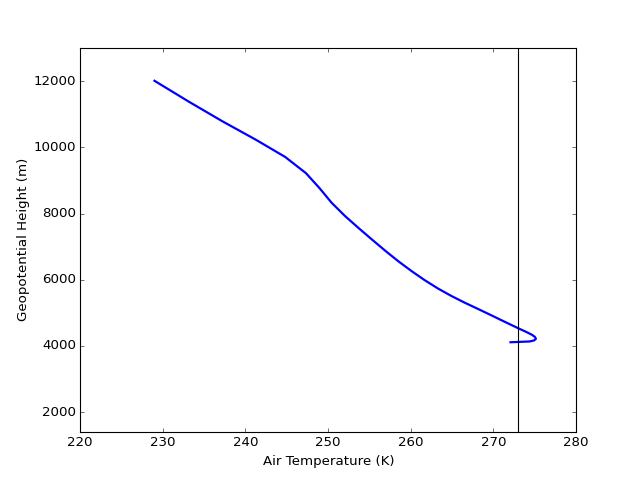

In [99]:
ta = tair[0,:,0,0]
hgt = z[0,:,0,0]
fig = plt.figure()
plt.plot(ta,hgt, linewidth=2)
plt.ylim(1400,13000)
plt.xlabel("Air Temperature (K)")
plt.ylabel("Geopotential Height (m)")
plt.axvline(273.,color="k")

You can see from the profile that there is a steep low level inversion.  This can cause problems when extrapolating to lower elevations because the steep gradient will result in very low temperatures.  To avoid this problem, I only use temperatures above the inversion to calculate the lapse rate.

This means I have to find the model levels above the inversion.

To do this I calculate the gradient of temperature using the numpy gradient method.  This calculates the gradient as a central difference.  All levels with a positive gradient are above the inversion.

In [100]:
dydx = np.gradient(ta)

I also don't want to use levels above the maximum expected elevation of the land surface.  In this case, I use 8000 m as the maximum elevation.

I select the levels above the inversion and below 8000 m using logic statements.

In [107]:
hp = hgt[(dydx > 0) & (hgt < 8000.)]
tp = ta[(dydx > 0) & (hgt < 8000.)]

To understand what is going on here, lets look at the statement y < 8000.

In [108]:
hgt < 8000.

array([False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True], dtype=bool)

This returns a boolean array with elements that are either True or False.  A cool thing about numpy arrays is that we can select array elements, also called a "slice" of an array, based on a boolean array.  We do this below.  First, lets print the heights of model levels in y.

In [109]:
print hgt

[ 12009.97460938  11377.22265625  10786.24609375  10231.45507812
   9709.56347656   9218.88183594   8758.57910156   8327.07421875
   7922.68798828   7543.6796875    7188.60742188   6856.57080078
   6546.54882812   6258.11865234   5990.45117188   5742.90722656
   5514.78173828   5305.95507812   5115.55957031   4943.54101562
   4789.89013672   4653.40039062   4533.77197266   4430.89501953
   4343.72216797   4271.82177734   4214.18212891   4167.00830078
   4134.98388672   4111.34716797]


Next print the heights but only for levels below 8000.

In [110]:
hgt[hgt < 8000.]

array([ 7922.68798828,  7543.6796875 ,  7188.60742188,  6856.57080078,
        6546.54882812,  6258.11865234,  5990.45117188,  5742.90722656,
        5514.78173828,  5305.95507812,  5115.55957031,  4943.54101562,
        4789.89013672,  4653.40039062,  4533.77197266,  4430.89501953,
        4343.72216797,  4271.82177734,  4214.18212891,  4167.00830078,
        4134.98388672,  4111.34716797], dtype=float32)

Finally, we can combine logic statements using the logical AND and OR.  Here we use AND, represented by & in the code, because we want levels below 8000 m AND above the height where gradient is zero. 

In [111]:
hgt[(dxdz > 0) & (hgt < 8000.)]

array([ 7922.68798828,  7543.6796875 ,  7188.60742188,  6856.57080078,
        6546.54882812,  6258.11865234,  5990.45117188,  5742.90722656,
        5514.78173828,  5305.95507812,  5115.55957031,  4943.54101562,
        4789.89013672,  4653.40039062,  4533.77197266,  4430.89501953,
        4343.72216797,  4271.82177734], dtype=float32)

Let's plot the original profile and overlay the profile segment above the inversion and below 8000 m.

<IPython.core.display.Javascript object>


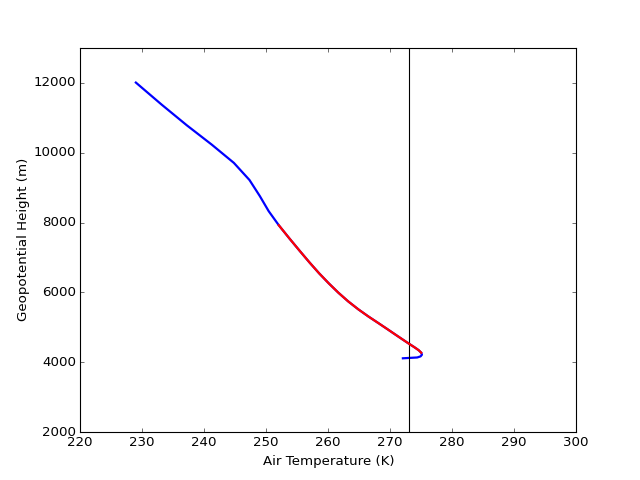

In [112]:
fig = plt.figure()
plt.plot(ta,hgt, linewidth=2)
plt.ylim(2000,13000)
plt.xlim(220,300)
plt.xlabel("Air Temperature (K)")
plt.ylabel("Geopotential Height (m)")
plt.axvline(273.,color="k")
plt.plot(tp,hp,color='r', linewidth=2)

Now, I want to estimate the temperature gradient for the segment we have selected.  As I am interested in a linear gradient, I can used linear regression to get the temperature gradient or slope.

I use the linregress method from the scipy package to do this.  I also want the intercept.  linregress also returns other information such as the r_value, p_value and standard error.  I don't use these because I am only interested in fitting a slope to my profile.

In [115]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(hp,tp)

Let's take a look at the values of the slope (temperature gradient)

In [116]:
print slope
print intercept

-0.00650597560463
301.881781999


The temperature gradient (slope) is -0.0065, which is pretty much the global average environmental lapse rate.  The intercept, which is the air temperature extrapolated to 0 m, is 302 K.

We can plot the temperature gradient but first have to calculate the gradient line.  We do this by using the slope and intercept in the equation of a line.

##$$y = mx + c$$

In [117]:
hl = np.array([0.,8000.])
tl = (hl*slope)+intercept
print tl

[ 301.881782    249.83397716]


<IPython.core.display.Javascript object>


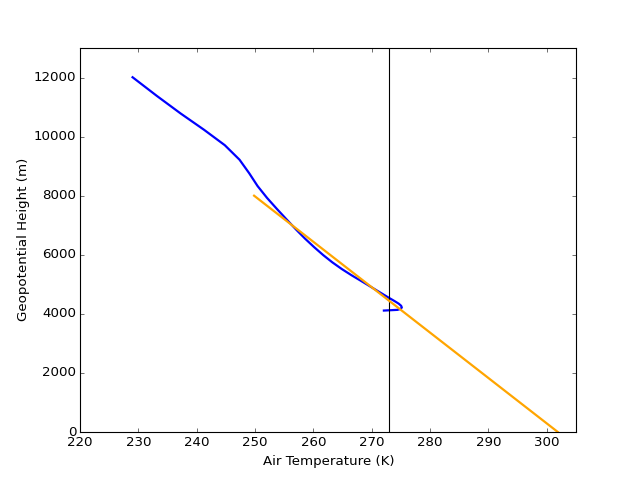

In [120]:
fig = plt.figure()
plt.plot(ta,hgt,linewidth=2)
plt.ylim(0,13000)
plt.xlim(220,305)
plt.xlabel("Air Temperature (K)")
plt.ylabel("Geopotential Height (m)")
plt.axvline(273.,color="k")
plt.plot(tl,hl,color='orange',linewidth=2)